We implement a "sequential" version of a Hogwild Gibbs sampler, where the $n$ processors that are supposed to work in parallel are just simulated sequentially.

The goal is to compare the mixing time of the chains in the case of a batched implementation and of a sequential one.

In [45]:
import numpy as np
from tqdm import tqdm
import numpy as np
from utils import one_hot_encode
from sequential import *
from sbm import *

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from sbm_class import *
from neal_batched import *
from neal_sequential import *
from batched import *
from sequential import *
from metrics import *

In [47]:
class BSP_hogwild_sampler():
    def __init__(self, A, z_0, alpha_p_pri, beta_p_pri, alpha_q_pri, beta_q_pri, pi_pri, n_proc = 8, iter = 10):
        
        # number of simulated processors
        self.n_proc = n_proc
        
        self.n = len(z_0)
        self.k = len(np.unique(z_0))
        
        # partition the data (n indexes) in the n_proc processors
        self.partition = np.array_split(np.arange(self.n), n_proc)
        # could be worth it to shuffle the partition indexes?

        # number of local iterations
        self.iter = iter

        # store A n_proc times in a list
        self.A = A

        # store z_0 n_proc times in a list
        self.z = [z_0.copy() for _ in range(n_proc)]

        self.alpha_p_pri = alpha_p_pri
        self.beta_p_pri = beta_p_pri
        self.alpha_q_pri = alpha_q_pri
        self.beta_q_pri = beta_q_pri
        self.pi_pri = pi_pri.copy()

        #lists for analyses
        self.z_list=[z_0.copy()]
        self.p_list=[]
        self.q_list=[]

        # for each processor, one_hot_encode the labels
        self.Z = [one_hot_encode(z_0) for _ in range(n_proc)]
        
        # initialize the beta parameters (shaped processor x 1)
        self.p = [[] for _ in range(self.n_proc)]
        self.q = [[] for _ in range(self.n_proc)]
        self.alpha_p = np.ones(self.n_proc) * self.alpha_p_pri
        self.beta_p = np.ones(self.n_proc) * self.beta_p_pri
        self.alpha_q = np.ones(self.n_proc) * self.alpha_q_pri
        self.beta_q = np.ones(self.n_proc) * self.beta_q_pri
        self.pi = [self.pi_pri.copy() for _ in range(self.n_proc)]


    def __local_beta_updates(self, processor):
        """
        Update the beta parameters based on the current community assignments.
        Update is done locally on the processor data (only on the partition of the data).
        """
        A_lower = np.tril(self.A)
        cA_lower = np.tril(np.ones((self.n, self.n))) - np.eye(self.n) - A_lower
        
        U = self.Z[processor].T @ A_lower @ self.Z[processor]
        cU = self.Z[processor].T @ cA_lower @ self.Z[processor]

        self.alpha_p[processor] = self.alpha_p_pri + np.sum(np.diag(U))
        self.beta_p[processor] = self.beta_p_pri + np.sum(np.diag(cU))

        # set the diagonal elements to 0
        np.fill_diagonal(U, 0)
        np.fill_diagonal(cU, 0)

        self.alpha_q[processor] = self.alpha_q_pri +  np.sum(U)
        self.beta_q[processor] = self.beta_q_pri + np.sum(cU)

        self.p[processor] = np.random.beta(self.alpha_p[processor], self.beta_p[processor])
        self.q[processor] = np.random.beta(self.alpha_q[processor], self.beta_q[processor])

        # self.p_list.append(self.p)
        # self.q_list.append(self.q)
        return

    def __local_z_updates(self, processor):
        """
        Update the community assignments based on the current beta parameters.
        Only update the copy of the data on the processor.
        Updates only involve the partition of the data.
        """
        # compute useful quantities
        t = np.log((self.p[processor] * (1-self.q[processor])) / ((1-self.p[processor]) * self.q[processor]))/2
        lambd = np.log((1-self.q[processor])/(1-self.p[processor])) / (2*t)
        lambd_mat = lambd * ( np.ones((self.n, self.n)) - np.eye(self.n) )

        for i in self.partition[processor]:
            self.pi[processor][i, :] = self.pi_pri[i,:] * np.exp(
                2 * t * (
                    self.A[i, :]-lambd_mat[i, :]
                    ).reshape(1, -1) @ self.Z[processor]
                    )
            
            # # check shape of pi
            # assert self.pi[processor][i, :].shape == (self.k,)
                    
            self.pi[processor][i, :] = self.pi[processor][i, :] / np.sum(self.pi[processor][i, :])
            # sample z from pi
            self.z[processor][i] = np.random.choice(self.k, p=self.pi[processor][i, :])
            # update the one hot encoding of Z
            self.Z[processor][i, :] = np.zeros(self.k)
            self.Z[processor][i, self.z[processor][i]] = 1
        # append the z values to the list only after each synchronization
        # if append:
        #     self.z_list.append(self.z.copy())

    def __beta_synchronization(self):
        """
        Compute the "synchronized" beta parameters.
        """
        A_lower = np.tril(self.A)
        cA_lower = np.tril(np.ones((self.n, self.n))) - np.eye(self.n) - A_lower

        U = self.Z[0].T @ A_lower @ self.Z[0]
        cU = self.Z[0].T @ cA_lower @ self.Z[0]

        alpha_p = self.alpha_p_pri + np.sum(np.diag(U))
        beta_p = self.beta_p_pri + np.sum(np.diag(cU))

        # set the diagonal elements to 0
        np.fill_diagonal(U, 0)
        np.fill_diagonal(cU, 0)

        alpha_q = self.alpha_q_pri +  np.sum(U)
        beta_q = self.beta_q_pri + np.sum(cU)

        p = np.random.beta(alpha_p, beta_p)
        q = np.random.beta(alpha_q, beta_q)

        return p, q

    def __synchronize(self):
        # copy the community assignments of other processors all in processor 0
        for i in range(1, self.n_proc):
            self.z[0][self.partition[i]] = self.z[i][self.partition[i]]
            self.Z[0][self.partition[i], :] = self.Z[i][self.partition[i], :]
            self.pi[0][self.partition[i], :] = self.pi[i][self.partition[i], :]

        # update the community assignments of the other processors
        for i in range(1, self.n_proc):
            self.z[i] = self.z[0].copy()
            self.Z[i] = self.Z[0].copy()
            self.pi[i] = self.pi[0].copy()
        
        # append the z values to the list
        self.z_list.append(self.z[0].copy())
        
        # compute the "synchronized" beta parameters
        p, q = self.__beta_synchronization()

        self.p_list.append(p)
        self.q_list.append(q)

        return
        


    def step(self, append_z=True):
        """
        Perform one step of the Gibbs sampling algorithm.

        Parameters:
        - append_z: bool, whether to append the current community assignments to the z_list

        Returns:
        None
        """
        # SHOULD FIX BURN IN HERE (not important for now)

        # for each processor, update the beta parameters and the community assignments
        for processor in range(self.n_proc):
            self.__local_beta_updates(processor)
            self.__local_z_updates(processor)
        # synchronize the data
        self.__synchronize()

    
    def run(self, num_iterations, burn_in=0):
        """
        Run the Gibbs sampler for a specified number of iterations.

        Parameters:
        - num_iterations: int, number of iterations to run the sampler
        - burn_in: int, number of burn-in iterations to discard

        Returns:
        None
        """
        for t in tqdm(range(num_iterations)):
            # self.step(append_z=(t >= burn_in))
            self.step()

    def get_z_list(self):
        """
        Get the list of community assignments at each step.

        Returns:
        list: list of numpy arrays representing community assignments
        """
        return self.z_list
    
    def get_p_list(self):
        """
        Get the list of sampled p values at each step.

        Returns:
        list: list of floats representing sampled p values
        """
        return self.p_list
    
    def get_q_list(self):
        """
        Get the list of sampled q values at each step.

        Returns:
        list: list of floats representing sampled q values
        """
        return self.q_list



In [48]:
# test the sampler

# initialization parameter
alpha = 0.5
# set parameters for the network
n = 400
k = 4
p = 0.3
q = 0.1
# set parameters for the samplers
n_iter = 20
burn_in = 0

alpha_p = 1
beta_p = 1
alpha_q = 1
beta_q = 1

# changing parameters
pi = np.ones((n,k)) # deterministic prior

# generate the adjacency matrix
# generate the network
sbm = Homogeneous_SBM(n, k, p, q, Neal=False)
A = sbm.get_A()
z = sbm.get_z()
# warm initialization
z_init = warm_initializer(z, alpha, n, k)


In [57]:
sampler = BSP_hogwild_sampler(A, z_init, alpha_p, beta_p, alpha_q, beta_q, pi_pri = pi, n_proc=1, iter=1)
sampler.run(n_iter, burn_in)


100%|██████████| 20/20 [00:00<00:00, 30.97it/s]


In [58]:
# comparison with the batched one
batched = batched_Gibbs_sampler(A, z_init, alpha_p, beta_p, alpha_q, beta_q, pi_pri = pi)
batched.run(n_iter, burn_in)

# get lists and losses
z_list_batched = batched.get_z_list()
p_list_batched = batched.get_p_list()
q_list_batched = batched.get_q_list()

loss_batched = [loss(z_list_batched[i], z)[0] for i in range(len(z_list_batched))]

100%|██████████| 20/20 [00:00<00:00, 107.91it/s]


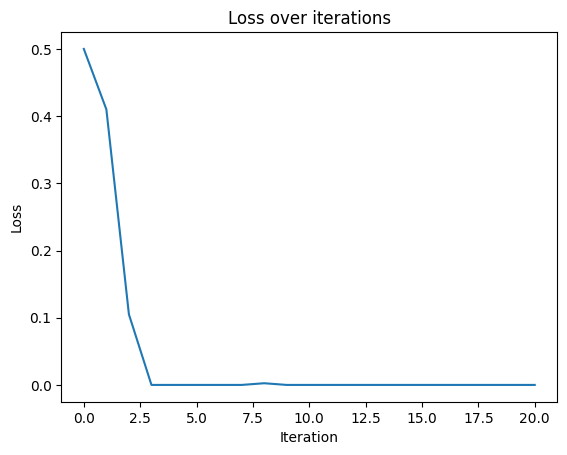

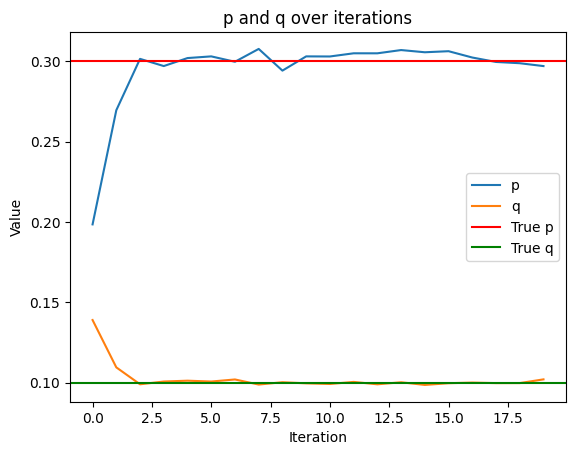

In [59]:
# get the z, p, q lists
z_list = sampler.get_z_list()
p_list = sampler.get_p_list()
q_list = sampler.get_q_list()

# compute the metrics
losses = [loss(z_list[i], z)[0] for i in range(len(z_list))]

# plot the metrics
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.show()

# plot the values of p and q, with lines indicating the true ones
plt.plot(p_list, label="p")
plt.plot(q_list, label="q")
plt.axhline(y=p, color='r', linestyle='-', label="True p")
plt.axhline(y=q, color='g', linestyle='-', label="True q")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("p and q over iterations")
plt.show()


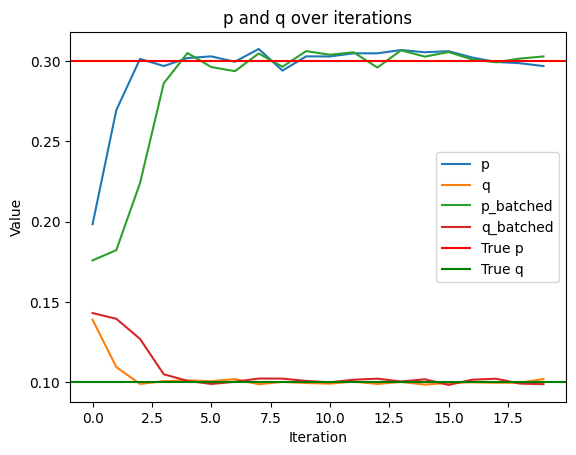

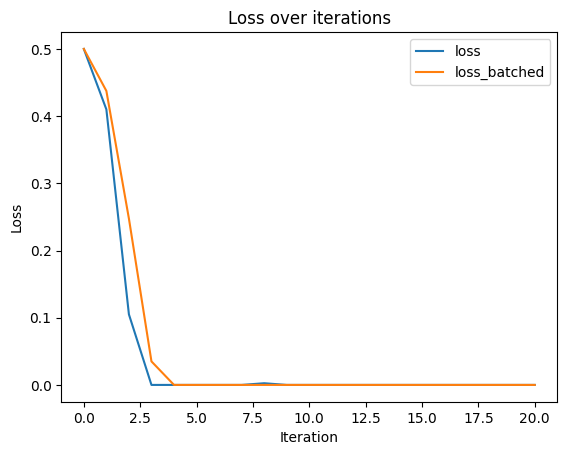

In [60]:
# repeat the plot but with the batched too

# plot the values of p and q, with lines indicating the true ones
plt.plot(p_list, label="p")
plt.plot(q_list, label="q")
plt.plot(p_list_batched, label="p_batched")
plt.plot(q_list_batched, label="q_batched")
plt.axhline(y=p, color='r', linestyle='-', label="True p")
plt.axhline(y=q, color='g', linestyle='-', label="True q")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("p and q over iterations")
plt.show()

# plot the metrics
plt.plot(losses, label="loss")
plt.plot(loss_batched, label="loss_batched")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss over iterations")
plt.legend()
plt.show()
